# Train an EBM with one or two objectives on Gaussian mixture data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import torch

from tqdm.notebook import tqdm, trange

from main import *

params = {
      'text.usetex': True,
      'font.family': 'sans serif'
}
matplotlib.rcParams.update(params)

## Single and dual score matching training

In [2]:
d = 1_000

def radial_gm_energies(r, sigma, p):
    """ r: (N...,), sigma: (K,), p: (K,) to (N..., K). """
    return 1/2 * (r[..., None] / sigma) ** 2 + d/2 * torch.log(2 * np.pi * sigma ** 2) - torch.log(p)

def radial_gm_energy(r, sigma, p):
    """ r: (N...,), sigma: (K,), p: (K,) to (N...,). """
    energies = radial_gm_energies(r, sigma, p)  # (N..., K)
    return -torch.logsumexp(-energies, dim=-1)  # (N...,)

def radial_gm_score(r, sigma, p):
    """ r: (N...,), sigma: (K,), p: (K,) to (N...,). """
    energies = radial_gm_energies(r, sigma, p)  # (N..., K)
    scores = r[..., None] / sigma ** 2  # (N..., K)
    return torch.sum(torch.softmax(-energies, dim=-1) * scores, dim=-1)  # (N..., D)

def radial_gm_time_score(r, sigma, p):
    """ r: (N...,), sigma: (K,), p: (K,) to (N...,). """
    energies = radial_gm_energies(r, sigma, p)  # (N..., K)
    scores = d / (2 * sigma ** 2) -  r[..., None] ** 2 / (2 * sigma ** 4)  # (N..., K)
    return torch.sum(torch.softmax(-energies, dim=-1) * scores, dim=-1)  # (N..., D)


device = torch.device("cuda")
sigma = torch.tensor([1, 4], device=device)
p = 0.5
p = torch.tensor([p, 1 - p], device=device)
t = 0

n = 100_000
k = torch.multinomial(p, num_samples=n, replacement=True).to(device)  # (N,)
xs = torch.sqrt(sigma[k] ** 2 + t)[:, None] * torch.randn((n, d), device=device)  # (N, D)
r = torch.linalg.norm(xs, dim=-1)  # (N,)

r0 = np.sqrt(d) * torch.linspace(0, 5 + t, 500, device=device)
true_energy = radial_gm_energy(r0, sigma, p)  # (N, K)

noise.s = SignalShape(1)

def get_energies(dual_objective):
    t_min = 1e-2
    t_max = 1e2

    class SimpleEBM(nn.Module):
        def __init__(self, hidden_dim, num_hidden_layers):
            super().__init__()
            self.model = nn.Sequential(*[nn.Sequential(nn.Linear(1 if i == 0 else hidden_dim, hidden_dim), nn.GELU()) for i in range(num_hidden_layers)] + [nn.Linear(hidden_dim, 4)])
            # self.model[-1].bias[1].data += 1
            # self.model[-1].bias[2].data += 3

        def forward_r(self, r, t):   # (B,) and (B,) to (B,)
            coeffs = self.model(torch.log(t + t_min)[:, None])  # (B, 4)
            a = coeffs[:, :2]  # (B, 2)
            b = d * coeffs[:, 2:]  # (B, 2)
            e = a * r[:, None] ** 2 + b  # (B, 2)
            return -torch.logsumexp(-e, dim=-1)  # (B,)

        def forward(self, x, t):   # (B, D) and (B,) to (B,)
            return self.forward_r(torch.linalg.norm(x, dim=-1), t)

    network = SimpleEBM(hidden_dim=256, num_hidden_layers=4)
    model = EnergyModel(network, dataset_info=None, noise_covariance=IdentityCovariance())
    lr_0 = 0.0001  # TODO REDUCED FROM 0.0002
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_0)
    dataset = torch.utils.data.TensorDataset(xs)  # (N, D)
    sampler = InfiniteSampler(dataset, seed=0)
    dataloader = DataLoader(dataset, batch_size=512, sampler=sampler, num_workers=0)
    n_steps = 20_000
    noise_level_sampler = UniformLog(min=NoiseLevel(dataset_info=None, variance=t_min), max=NoiseLevel(dataset_info=None, variance=t_max)) # if dual_objective else t_min))

    losses = []
    for i, x in enumerate(tqdm(dataloader, total=n_steps)):
        if i >= n_steps:
            break
        elif i % (n_steps // 10) == 0:
            lr = lr_0 / (2 ** (i // (n_steps // 10)))  # Recalculate learning rate to work nicely with resumes.
            for param_group in optim.param_groups:
                param_group["lr"] = lr

        x = x[0]  # (B, D)
        batch = noisy_batch(x, noise_level_sampler)  # (B, D)
        input = ModelInput.from_batch(batch)  # (B, D)
        # print("input", input.noisy.shape, input.noise_level.shape)
        output = model(input)
        # print("output", output.energy.shape, output.data_score.shape)
        mse_loss = torch.mean((output.denoised - batch.clean) ** 2, dim=-1) / batch.noise_level.variance  # (B,)
        if dual_objective:
            target = 1 - torch.mean((batch.noisy - batch.clean) ** 2, dim=-1) / batch.noise_level.variance  # (B,)
            # print(tensor_summary_stats(target / 2), tensor_summary_stats(batch.noise_level.variance * output.noise_score / d))
            time_loss = (target / 2 - batch.noise_level.variance * output.noise_score / d) ** 2  # (B,)
        else:
            time_loss = 0
        # print(tensor_summary_stats(mse_loss), tensor_summary_stats(time_loss))
        loss = (mse_loss + time_loss).mean()  # (,)
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.detach())

    # Compute energies at t=0 and normalization constant.
    with torch.no_grad():
        y = model_input(xs, t_max)
        avg_e = model(y, compute_scores=False).energy.mean()
        log_normalization_constant = d/2 * np.log(2 * np.pi * np.e * t_max) - avg_e
        e0 = network.forward_r(r0, torch.zeros_like(r0) + t_min) + log_normalization_constant
        e1 = network.forward_r(r, torch.zeros_like(r) + t_min) + log_normalization_constant

    return torch.stack(losses, dim=0), model, log_normalization_constant, e0, e1

# losses_dual, model_dual, norm_dual, e_dual_grid, e_dual_data = get_energies(dual_objective=True)
# plot_lines(losses_dual, yscale="log")
# losses_single, model_single, norm_single, e_single_grid, e_single_data = get_energies(dual_objective=False)
# plot_lines(losses_single, yscale="log")
# torch.save((norm_dual, e_dual_grid, e_dual_data, norm_single, e_single_grid, e_single_data), "outputs/single_vs_dual_sm.pt")
norm_dual, e_dual_grid, e_dual_data, norm_single, e_single_grid, e_single_data = torch.load("outputs/single_vs_dual_sm.pt")

## Plotting energy and score

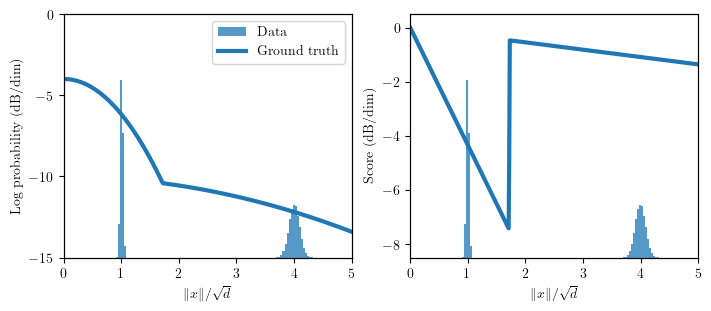

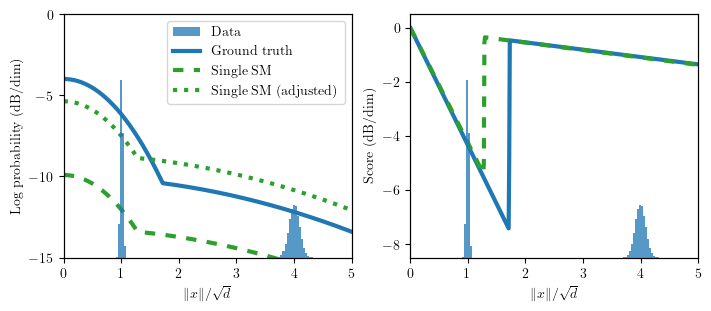

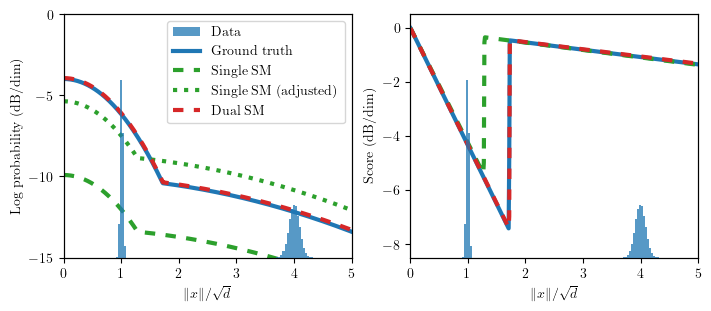

In [4]:
true_color = "tab:blue"
single_color = "tab:green"
dual_color = "tab:red"
dashes = (0, (2.5, 2.5))
from plotting import plot_lines

for i in range(3):  # Animate plot
    fig, axs = plt.subplots(figsize=(7,3), ncols=2, layout="constrained")
    # fig.suptitle("Single and dual score matching on a Gaussian scale mixture")

    plt.sca(axs[0])
    conv = lambda e: -10 * e / (d * np.log(10))
    plot_lines(conv(true_energy), x=r0 / np.sqrt(d), color=true_color, has_fig=True, grid=False, label="Ground truth", linewidth=3)
    # plot_lines(*(conv(r0**2/(2 * sigma[i]**2) + d/2*torch.log(2*np.pi*sigma[i]**2)) for i in range(2)), x=r0 / np.sqrt(d), color="tab:blue", has_fig=True, linestyle=":")
    if i >= 1:
        plot_lines(conv(e_single_grid) + 3, x=r0 / np.sqrt(d), color=single_color, has_fig=True, grid=False, linestyle=dashes, label="Single SM", linewidth=3)
        n = len(true_energy)
        true_entropy = radial_gm_energy(r, sigma, p).mean()
        cst = true_entropy - e_single_data.mean()
        plot_lines(conv(e_single_grid + cst), x=r0 / np.sqrt(d), color=single_color, has_fig=True, grid=False, linestyle=":", label="Single SM (adjusted)", linewidth=3)
    if i >= 2:
        plot_lines(conv(e_dual_grid), x=r0 / np.sqrt(d), color=dual_color, has_fig=True, grid=False, linestyle=dashes, label="Dual SM", linewidth=3)
    plt.xlim(0, 5)
    plt.ylim(-15, 0)
    plt.yticks([0, -5, -10, -15])
    plt.xlabel(r"$\|x\|/\sqrt{d}$")
    plt.ylabel("Log probability (dB/dim)")
    # plt.legend(loc="upper right")
    twin = plt.twinx()
    plt.hist(r.cpu() / np.sqrt(d), density=True, bins=100, color=true_color, zorder=-1, alpha=0.75, label="Data", rasterized=True)
    plt.ylim(0, 10)
    plt.tick_params(axis='y', which='both', right=False, labelright=False)

    lines, labels = axs[0].get_legend_handles_labels()
    lines2, labels2 = twin.get_legend_handles_labels()
    plt.legend(lines2 + lines, labels2 + labels, loc="upper right")

    plt.sca(axs[1])
    delta = (r0[1] - r0[0]) / np.sqrt(d)
    r2 = (r0[1:] + r0[:-1]) / 2
    diff = lambda e: (e[1:] - e[:-1]) / delta
    plot_lines(diff(conv(true_energy)), x=r2 / np.sqrt(d), color=true_color, has_fig=True, grid=False, linewidth=3)
    if i >= 1:
        plot_lines(diff(conv(e_single_grid)), x=r2 / np.sqrt(d), color=single_color, has_fig=True, grid=False, linestyle=dashes, linewidth=3)
    if i >= 2:
        plot_lines(diff(conv(e_dual_grid)), x=r2 / np.sqrt(d), color=dual_color, has_fig=True, grid=False, linestyle=dashes, linewidth=3)
    plt.xlim(0, 5)
    plt.ylim(-8.5, 0.5)
    plt.xlabel(r"$\|x\|/\sqrt{d}$")
    plt.ylabel(r"Score (dB/dim)")
    plt.twinx()
    plt.hist(r.cpu() / np.sqrt(d), density=True, bins=100, color=true_color, zorder=-1, alpha=0.75, rasterized=True)
    plt.ylim(0, 10)
    plt.tick_params(axis='y', which='both', right=False, labelright=False)

    plt.savefig(f"outputs/single_vs_dual_sm_gsm_step{i}.pdf", transparent=True, bbox_inches="tight", pad_inches=0, dpi=600)
    plt.show()